# Explainable & fair machine learning - Dutch census

This notebook uses the dataset *Dutch census*, available from [GitHub](https://github.com/alku7660/counterfactual-fairness), to build and inspect machine learning models using [sklearn](https://scikit-learn.org/) and [fairlearn](https://fairlearn.org/).

This notebook is part of the tutorial **A hands-on tutorial on explainable methods for machine learning with Python: applications to gender bias**, 3rd EuADS Summer School – Data Science for Explainable and Trustworthy AI (7-9 June 2023)

Author: Aurora Ramírez (University of Córdoba)

## Methodology

The following steps will be done to train and test machine learning algorithms using the dataset:

1. Preprocessing data:
    - Load and clean the data
    - Prepare the dataset for training (conversion and split)
2. Learning from data without fairness awareness:
    - Train a classifier (GradientBoostingClassifier) for the complete dataset
    - Test the classifier in terms of performance and bias
    - Inspect the feature importances of the classifier (global explanation)
3. Use mitigation methods to reduce gender bias
    - Apply a postprocessing method to the classifier
    - Apply a mitigation method during training
4. Explaining predictions:
    - Inspect feature contributions for some test samples (local explanation)
5. Exploring what-if scenarios 
    - Provide recommendations for people classified as "low level" occupation (counterfactual explanation)

## Preprocessing data

### Library imports

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
import dalex as dx
import dice_ml

In [4]:
from ml_plots import make_confusion_matrix
from ml_plots import make_feature_importance_plot
import ml_performance as mlp
import xai_utils as xai

In [5]:
import warnings
warnings.simplefilter("ignore")

### Load data

In [6]:
data = pd.read_csv('../data/dutch_census.csv', index_col=0)

In [7]:
# Set features of interest
target_feat = 'Occupation'
gender_feat = 'Sex'

### Convert to numeric data

In [8]:
# Force categorical features
categorical_features = ['EducationLevel', 'HouseholdPosition', 'HouseholdSize', 'Country', 'EconomicStatus', 'CurEcoActivity', 'MaritalStatus']
for c in categorical_features:
    data[c] = data[c].astype('category')

# Convert types for binary columns
data['Sex'].replace([2], [0], inplace=True) # 1: Male, 2: Female (change to 0)

# For other features with more than 2 categories, use one-hot-encoding
data_non_num = data.select_dtypes(exclude=['int', 'float', 'bool'])
col_names = data_non_num.columns.values
dummies = pd.get_dummies(data[col_names], dtype='int')
data.drop(columns=col_names, inplace=True)
data = data.join(dummies)
display(data)


,Sex,Age,Occupation,EducationLevel_1,EducationLevel_2,EducationLevel_3,EducationLevel_4,EducationLevel_5,EducationLevel_6,HouseholdPosition_1,...,CurEcoActivity_7,CurEcoActivity_8,CurEcoActivity_9,CurEcoActivity_10,CurEcoActivity_11,CurEcoActivity_12,MaritalStatus_1,MaritalStatus_2,MaritalStatus_3,MaritalStatus_4
0,1,18,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1,0,32,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,22,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,42,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,59,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60415,1,32,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
60416,0,16,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
60417,1,37,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
60418,0,21,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0


### Split in train/test

In [9]:
# Train and test partition, stratified by target attribute
target_values = data[target_feat]
df_train, df_test, y_train, y_test = train_test_split(data,
                                                    target_values,
                                                    test_size=0.33,
                                                    random_state=0,
                                                    stratify=target_values)
x_train = df_train.drop(target_feat, axis=1)
x_test = df_test.drop(target_feat, axis=1)

# Some statistics
num_fem_train = df_train[df_train[gender_feat]==0].shape[0]
num_male_train = df_train[df_train[gender_feat]==1].shape[0]
perc_fem_train_high = np.round(df_train[(df_train[gender_feat]==0) & (df_train[target_feat]==1)].shape[0] / num_fem_train *100, decimals=2)
perc_male_train_high = np.round(df_train[(df_train[gender_feat]==1) & (df_train[target_feat]==1)].shape[0] / num_male_train *100, decimals=2)

print(f"Train -> female: {num_fem_train}, male: {num_male_train}, female (high): {perc_fem_train_high}%, male (high): {perc_male_train_high}%")

num_fem_test = df_test[df_test[gender_feat]==0].shape[0]
num_male_test = df_test[df_test[gender_feat]==1].shape[0]
perc_fem_test_promoted = np.round(df_test[(df_test[gender_feat]==0) & (df_test[target_feat]==1)].shape[0] / num_fem_test *100, decimals=2)
perc_male_test_promoted = np.round(df_test[(df_test[gender_feat]==1) & (df_test[target_feat]==1)].shape[0] / num_male_test *100, decimals=2)
print(f"Test -> female: {num_fem_test}, male: {num_male_test}, female (high): {perc_fem_test_promoted}%, male (high): {perc_male_test_promoted}%")


Train -> female: 20224, male: 20257, female (high): 67.2%, male (high): 37.61%
Test -> female: 10049, male: 9890, female (high): 67.46%, male (high): 37.09%


## Learning from data without fairness awareness

### Train and evalaute a classifier using sklearn

In [10]:
# Train and test the model
clf = GradientBoostingClassifier(random_state=0)
model_sklearn = clf.fit(x_train, y_train)
y_pred_sklearn = model_sklearn.predict(x_test)

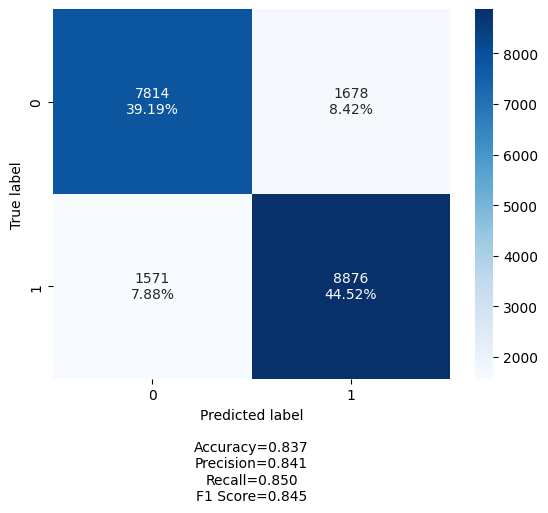

In [11]:
# Performance measures
cf_matrix = confusion_matrix(y_test, y_pred_sklearn)
make_confusion_matrix(cf_matrix)

In [12]:
# Inspecting TP by gender
df_tp = mlp.get_tp(df_test, y_test, y_pred_sklearn)

num_tp_fem = df_tp[df_tp[gender_feat]==0].shape[0]
perc_tp_fem = np.round(num_tp_fem / num_fem_test * 100, decimals=2)
num_tp_male = df_tp[df_tp[gender_feat]==1].shape[0]
perc_tp_male = np.round(num_tp_male / num_male_test * 100, decimals=2)

print(f"TP (female): {num_tp_fem}, percentage (all female in test): {perc_tp_fem}%")
print(f"TP (male): {num_tp_male}, percentage (all male in test): {perc_tp_male}%")

TP (female): 6351, percentage (all female in test): 63.2%
TP (male): 2525, percentage (all male in test): 25.53%


In [13]:
# Inspecting FP errors by gender
df_fp = mlp.get_fp(df_test, y_test, y_pred_sklearn)

num_fp_fem = df_fp[df_fp[gender_feat]==0].shape[0]
perc_fp_fem = np.round(num_fp_fem / num_fem_test * 100, decimals=2)
num_fp_male = df_fp[df_fp[gender_feat]==1].shape[0]
perc_fp_male = np.round(num_fp_male / num_male_test * 100, decimals=2)

print(f"FP (female): {num_fp_fem}, percentage (all female in test): {perc_fp_fem}%")
print(f"FP (male): {num_fp_male}, percentage (all male in test): {perc_fp_male}%")

FP (female): 820, percentage (all female in test): 8.16%
FP (male): 858, percentage (all male in test): 8.68%


In [14]:
# Inspecting TN by gender
df_tn = mlp.get_tn(df_test, y_test, y_pred_sklearn)
num_tn_fem = df_tn[df_tn[gender_feat]==0].shape[0]
perc_tn_fem = np.round(num_tn_fem / num_fem_test * 100, decimals=2)
num_tn_male = df_tn[df_tn[gender_feat]==1].shape[0]
perc_tn_male = np.round(num_tn_male / num_male_test * 100, decimals=2)

print(f"TN (female): {num_tn_fem}, percentage (all female in test): {perc_tn_fem}%")
print(f"TN (male): {num_tn_male}, percentage (all male in test): {perc_tn_male}%")

TN (female): 2450, percentage (all female in test): 24.38%
TN (male): 5364, percentage (all male in test): 54.24%


In [15]:
# Inspecting FN errors by gender
df_fn = mlp.get_fn(df_test, y_test, y_pred_sklearn)
num_fn_fem = df_fn[df_fn[gender_feat]==0].shape[0]
perc_fn_fem = np.round(num_fn_fem / num_fem_test * 100, decimals=2)
num_fn_male = df_fn[df_fn[gender_feat]==1].shape[0]
perc_fn_male = np.round(num_fn_male / num_male_test * 100, decimals=2)

print(f"FN (female): {num_fn_fem}, percentage (all female in test): {perc_fn_fem}%")
print(f"FN (male): {num_fn_male}, percentage (all male in test): {perc_fn_male}%")

FN (female): 428, percentage (all female in test): 4.26%
FN (male): 1143, percentage (all male in test): 11.56%


### Fairness assessment with fairlearn metrics

In [16]:
# Define a subset of metrics
fairness_metrics = {
    "count": count,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_negative_rate": false_negative_rate,
}

In [17]:
# Get the metrics by group (sensitive feature), difference between groups and overall
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_sklearn,
    sensitive_features=df_test[gender_feat]
)
print('== Metrics by gender ==')
print(metricframe_unmitigated.by_group)

print('== Metric differences ==')
print(metricframe_unmitigated.difference())

print('== Overall metrics ==')
print(metricframe_unmitigated.overall)

== Metrics by gender ==
       count  selection_rate  false_positive_rate  false_negative_rate
Sex                                                                   
0    10049.0        0.713603             0.250765             0.063136
1     9890.0        0.342063             0.137898             0.311614
== Metric differences ==
count                  159.000000
selection_rate           0.371541
false_positive_rate      0.112867
false_negative_rate      0.248478
dtype: float64
== Overall metrics ==
count                  19939.000000
selection_rate             0.529314
false_positive_rate        0.176780
false_negative_rate        0.150378
dtype: float64


In [18]:
# This metric obtains the greater of two metrics: true_positive_rate_difference and false_positive_rate_difference
# If the metric is equal to 0, all groups have the same TP/TN/FP/FN rates (totally fair).
eod_sklearn = equalized_odds_difference(y_true=y_test, y_pred=y_pred_sklearn, sensitive_features=df_test[gender_feat])
print(f"Equalized odds difference (sklearn): {eod_sklearn}")


Equalized odds difference (sklearn): 0.24847780278533538


### Feature importance (global explanation)

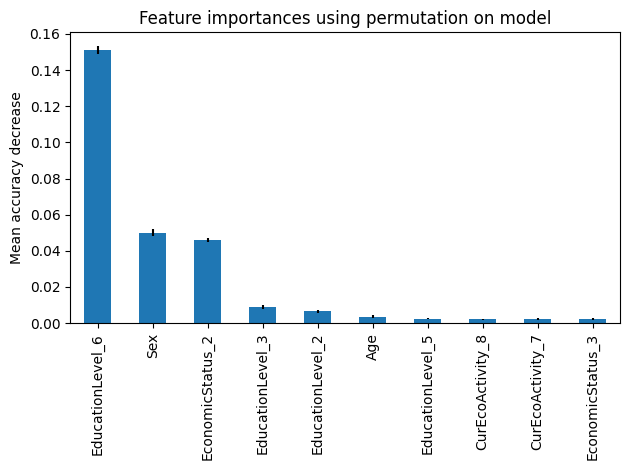

In [19]:
# 10 most important features for prediction
make_feature_importance_plot(model_sklearn, x_test, y_test, model_sklearn.feature_names_in_, 10)

## Mitigating classifier gender bias with fairlearn

### Mitigating gender bias after training
We can use a post-processing method from the fairlearn library to mitigate gender bias after prediction. The [ThresholdOptimizer](https://fairlearn.org/v0.8/api_reference/fairlearn.postprocessing.html?highlight=thresholdoptimizer#fairlearn.postprocessing.ThresholdOptimizer) creates a new classifier based on an already fitted one, looking for group-specific thresholds to optimize a fairness metric.

In [20]:
# Configure the postprocessing method
model_fairlearn_post = ThresholdOptimizer(
    estimator=model_sklearn,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

In [21]:
# Fit the new model and use it to get new predictions
model_fairlearn_post.fit(X=x_train, y=y_train, sensitive_features=df_train[gender_feat])
y_pred_fairlearn_post = model_fairlearn_post.predict(x_test, sensitive_features=df_test[gender_feat])

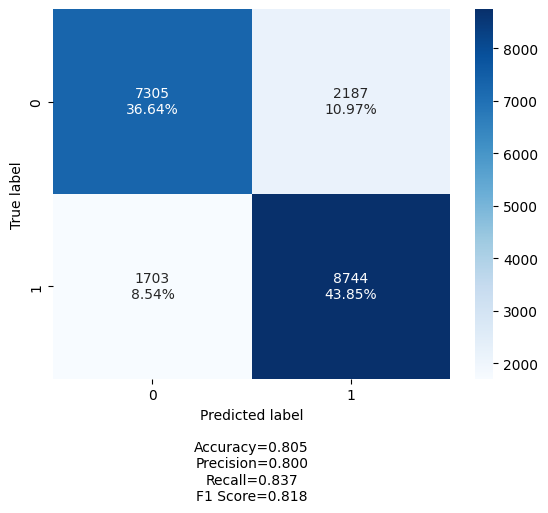

In [22]:
# The new confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_fairlearn_post)
make_confusion_matrix(cf_matrix)

In [23]:
# The new fairness metrics
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_fairlearn_post,
    sensitive_features=df_test[gender_feat]
)
print('== Metrics by gender ==')
print(metricframe_unmitigated.by_group)

print('== Metric differences ==')
print(metricframe_unmitigated.difference())

print('== Overall metrics ==')
print(metricframe_unmitigated.overall)

== Metrics by gender ==
       count  selection_rate  false_positive_rate  false_negative_rate
Sex                                                                   
0    10049.0        0.639566             0.224159             0.160053
1     9890.0        0.455410             0.233687             0.168484
== Metric differences ==
count                  159.000000
selection_rate           0.184157
false_positive_rate      0.009528
false_negative_rate      0.008431
dtype: float64
== Overall metrics ==
count                  19939.000000
selection_rate             0.548222
false_positive_rate        0.230405
false_negative_rate        0.163013
dtype: float64


In [24]:
# Check if the equalized odds difference has been improved
eod_fairlearn_post = equalized_odds_difference(y_true=y_test, y_pred=y_pred_fairlearn_post, sensitive_features=df_test[gender_feat])
print(f"Equalized odds difference (fairlearn+postprocessing): {eod_fairlearn_post}")

Equalized odds difference (fairlearn+postprocessing): 0.009527895983178963


### Mitigating gender bias during training

We can also tackle the gender bias problem during training. The fairlearn libray provides several *reduction* methods, such as [ExponentiatedGradient](https://fairlearn.org/v0.8/api_reference/fairlearn.reductions.html#fairlearn.reductions.ExponentiatedGradient). This method allows choosing a base estimator and set constraints in terms of fairness metrics. The method will create several estimators using delta increments of the fairness metric.

In [25]:
# Configure the method
# For epsilon, values around 1/sqrt(samples) are recommended (0.004)
exp_grad_est = ExponentiatedGradient(
        estimator=GradientBoostingClassifier(random_state=0),
        constraints=EqualizedOdds(difference_bound=0.004),
)

In [26]:
# Fit and get the inner predictors
exp_grad_est.fit(x_train, y_train, sensitive_features=df_train[gender_feat])
predictors = exp_grad_est.predictors_
print(f"Number of predictors: {len(predictors)}")

Number of predictors: 10


In [27]:
# Get the equalized odds difference for each predictor and keep the best one
eod_values = []
predictor_idx = range(0, len(predictors))

best_eod = np.inf
model_fairlearn_training = None
for p in predictors:
    y_pred = p.predict(x_test)
    eod = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=df_test[gender_feat])
    eod_values.append(eod)
    if eod < best_eod:
        model_fairlearn_training = p
        best_eod = eod
df_eof = pd.DataFrame(data={'predictor':predictor_idx, 'eod':eod_values})
display(df_eof)   

,predictor,eod
0,0,0.248478
1,1,0.069072
2,2,0.169121
3,3,0.764528
4,4,0.719383
5,5,0.094336
6,6,0.887405
7,7,0.102037
8,8,0.829904
9,9,0.059718


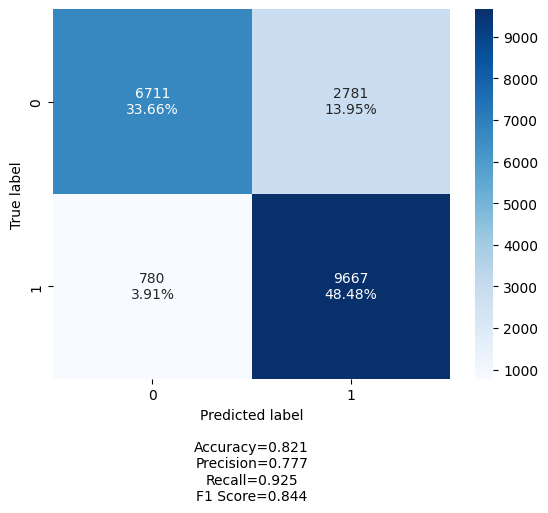

In [28]:
# The confusion matrix of the best model
y_pred_fairlearn_training = model_fairlearn_training.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix)

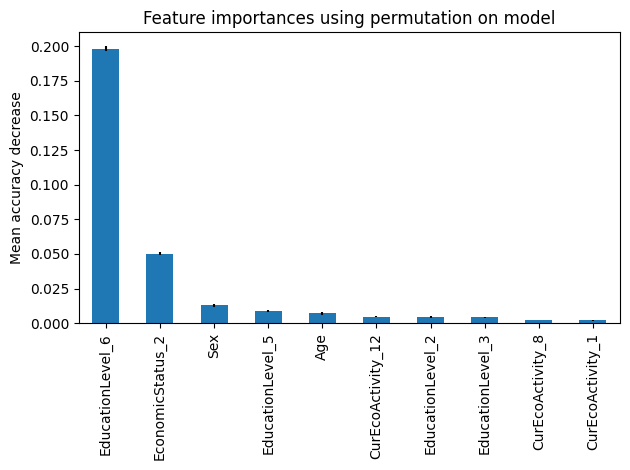

In [29]:
# Feature importance (fairlearn during training)
make_feature_importance_plot(model_fairlearn_training, x_test, y_test, model_fairlearn_training.feature_names_in_, 10)

## Explaining predictions

### Original classifier (sklearn)

In [30]:
# Configure local explainer for the full model
explainer = dx.Explainer(model=model_sklearn, data=x_train, y=y_train, label="Classifier (sklearn)")

Preparation of a new explainer is initiated

  -> data              : 40481 rows 44 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 40481 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Classifier (sklearn)
  -> predict function  : <function yhat_proba_default at 0x000001E95D754EE0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0175, mean = 0.524, max = 0.991
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.988, mean = 8.3e-06, max = 0.969
  -> model_info        : package sklearn

A new explainer has been created!


In [31]:
# Remove target feature from data frames
df_tp.drop([target_feat], axis=1, inplace=True)
df_fp.drop([target_feat], axis=1, inplace=True)
df_tn.drop([target_feat], axis=1, inplace=True)
df_fn.drop([target_feat], axis=1, inplace=True)

In [32]:
# Local explanation for female with high occupation (good prediction)
female_tp_sample = df_tp[df_tp[gender_feat]==0][0:1]
expl = explainer.predict_parts(female_tp_sample, type='break_down')
expl.plot()

In [33]:
# Local explanation for female with low occupation (good prediction)
female_tn_sample = df_tn[df_tn[gender_feat]==0][0:1]
expl = explainer.predict_parts(female_tn_sample, type='shap')
expl.plot()

In [34]:
# Local explanation for male with high occupation (good prediction)
male_tp_sample = df_tp[df_tp[gender_feat]==1][0:1]
expl = explainer.predict_parts(male_tp_sample, type='break_down')
expl.plot()

In [35]:
# Local explanation for male with low occupation (good prediction)
male_tn_sample = df_tn[df_tn[gender_feat]==1][0:1]
expl = explainer.predict_parts(male_tn_sample, type='shap')
expl.plot()

### Classifier with bias mitigation (fairlearn)

In [36]:
# Configure local explainer for the female model
explainer = dx.Explainer(model=model_fairlearn_training, data=x_train, y=y_train, label="Classifier (fairlearn)")

Preparation of a new explainer is initiated

  -> data              : 40481 rows 44 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 40481 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Classifier (fairlearn)
  -> predict function  : <function yhat_proba_default at 0x000001E95D754EE0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0204, mean = 0.586, max = 0.993
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.991, mean = -0.0622, max = 0.96
  -> model_info        : package sklearn

A new explainer has been created!


In [37]:
# Local explanation for female with high occupation (good original prediction)
expl = explainer.predict_parts(female_tp_sample, type='break_down')
expl.plot()

In [38]:
# Local explanation for female with low occupation (good original prediction)
expl = explainer.predict_parts(female_tn_sample, type='shap')
expl.plot()

In [39]:
# Local explanation for male with high occupation (good original prediction)
expl = explainer.predict_parts(male_tp_sample, type='break_down')
expl.plot()

In [40]:
# Local explanation for male with low occupation (good original prediction)
expl = explainer.predict_parts(male_tn_sample, type='shap')
expl.plot()

## Exploring what-if scenarios

### Original classifer (sklearn)

In [41]:
# Configure DiCE explainer
df_train_dice = x_train.copy()
df_train_dice['target'] = y_train
features = df_train_dice.columns.to_list()
features.remove('target')
dice_data = dice_ml.Data(dataframe=df_train_dice,
                continuous_features = features,
                outcome_name='target')
dice_model_sklearn = dice_ml.Model(model=model_sklearn, backend='sklearn', model_type='classifier')
dice_explainer_sklearn = dice_ml.Dice(dice_data, dice_model_sklearn, method='random')

In [42]:
# Configure some general parameters of the counterfactual generation process
# Number of counterfactuals to generate
num_cfs = 1

# Features that can vary (exclude gender)
features_to_vary = features.copy()
features_to_vary.remove(gender_feat)

In [43]:
# Most frequently recommended feature changes for females with low occupation (based on 1 counterfactual per sample)
num_samples = 100
num_cfs = 1
df_female_counterfactuals = pd.DataFrame(columns=df_tn.columns, data=[])
df_female_samples = pd.DataFrame(columns=df_tn.columns, data=[])

# Generate one counterfactual for each sample
for i in range(1, num_samples+1):
    female_sample = df_tn[df_tn[gender_feat]==0][i-1:i]
    permitted_range = {'Age': [female_sample['Age'], 65]}
    counterfactual = dice_explainer_sklearn.generate_counterfactuals(female_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0,
                                  verbose=False)
    df_female_samples = pd.concat([df_female_samples, female_sample])
    df_female_counterfactuals = pd.concat([df_female_counterfactuals, counterfactual.cf_examples_list[0].final_cfs_df])

# Get summary
female_cfs_summary = xai.get_summary_changes(df_female_samples, df_female_counterfactuals, num_cfs)
display(female_cfs_summary.sort_values('num_changes', ascending=False).head(10))

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


,feature,num_changes,max_difference
7,EducationLevel_6,38.0,-1.0
1,Age,22.0,40.0
34,CurEcoActivity_7,21.0,1.0
28,CurEcoActivity_1,15.0,1.0
35,CurEcoActivity_8,10.0,1.0
27,EconomicStatus_3,10.0,1.0
26,EconomicStatus_2,9.0,-1.0
4,EducationLevel_3,7.0,1.0
2,EducationLevel_1,6.0,1.0
3,EducationLevel_2,6.0,1.0


In [44]:
# Most frequently recommended feature changes for females with low occupation (based on 1 counterfactual per sample)
df_male_counterfactuals = pd.DataFrame(columns=df_tn.columns, data=[])
df_male_samples = pd.DataFrame(columns=df_tn.columns, data=[])

# Generate one counterfactual for each sample
for i in range(1, num_samples+1):
    male_sample = df_tn[df_tn[gender_feat]==1][i-1:i]
    permitted_range = {'Age': [male_sample['Age'], 65]}
    counterfactual = dice_explainer_sklearn.generate_counterfactuals(male_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0,
                                  verbose=False)
    df_male_samples = pd.concat([df_male_samples, male_sample])
    df_male_counterfactuals = pd.concat([df_male_counterfactuals, counterfactual.cf_examples_list[0].final_cfs_df])

# Get summary
male_cfs_summary = xai.get_summary_changes(df_male_samples, df_male_counterfactuals, num_cfs)
display(male_cfs_summary.sort_values('num_changes', ascending=False).head(10))

100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


,feature,num_changes,max_difference
7,EducationLevel_6,38.0,-1.0
1,Age,28.0,42.0
22,Country_1,20.0,-1.0
3,EducationLevel_2,15.0,1.0
27,EconomicStatus_3,14.0,1.0
4,EducationLevel_3,9.0,1.0
34,CurEcoActivity_7,9.0,1.0
21,HouseholdSize_6,6.0,1.0
14,HouseholdPosition_7,6.0,1.0
35,CurEcoActivity_8,5.0,1.0


### Classifier with mitigation bias (fairlearn)

In [45]:
# Configure DiCE explainer
dice_model_fairlearn = dice_ml.Model(model=model_fairlearn_training, backend='sklearn', model_type='classifier')
dice_explainer_fairlearn = dice_ml.Dice(dice_data, dice_model_fairlearn, method='random')

In [46]:
# Most frequently recommended feature changes for females with low occupation (based on 1 counterfactual per sample)
num_samples = 100
num_cfs = 1
df_female_counterfactuals = pd.DataFrame(columns=df_tn.columns, data=[])
df_female_samples = pd.DataFrame(columns=df_tn.columns, data=[])

# Generate one counterfactual for each sample
for i in range(1, num_samples+1):
    female_sample = df_tn[df_tn[gender_feat]==0][i-1:i]
    permitted_range = {'Age': [female_sample['Age'], 65]}
    counterfactual = dice_explainer_fairlearn.generate_counterfactuals(female_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0,
                                  verbose=False)
    df_female_samples = pd.concat([df_female_samples, female_sample])
    df_female_counterfactuals = pd.concat([df_female_counterfactuals, counterfactual.cf_examples_list[0].final_cfs_df])

# Get summary
female_cfs_summary = xai.get_summary_changes(df_female_samples, df_female_counterfactuals, num_cfs)
display(female_cfs_summary.sort_values('num_changes', ascending=False).head(10))

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


,feature,num_changes,max_difference
7,EducationLevel_6,39.0,-1.0
3,EducationLevel_2,15.0,1.0
1,Age,12.0,43.0
28,CurEcoActivity_1,8.0,1.0
27,EconomicStatus_3,8.0,1.0
35,CurEcoActivity_8,6.0,1.0
2,EducationLevel_1,6.0,1.0
34,CurEcoActivity_7,6.0,1.0
38,CurEcoActivity_11,6.0,1.0
26,EconomicStatus_2,5.0,-1.0


In [47]:
# Most frequently recommended feature changes for females with low occupation (based on 1 counterfactual per sample)
df_male_counterfactuals = pd.DataFrame(columns=df_tn.columns, data=[])
df_male_samples = pd.DataFrame(columns=df_tn.columns, data=[])

# Generate one counterfactual for each sample
for i in range(1, num_samples+1):
    male_sample = df_tn[df_tn[gender_feat]==1][i-1:i]
    permitted_range = {'Age': [male_sample['Age'], 65]}
    counterfactual = dice_explainer_fairlearn.generate_counterfactuals(male_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0,
                                  verbose=False)
    df_male_samples = pd.concat([df_male_samples, male_sample])
    df_male_counterfactuals = pd.concat([df_male_counterfactuals, counterfactual.cf_examples_list[0].final_cfs_df])

# Get summary
male_cfs_summary = xai.get_summary_changes(df_male_samples, df_male_counterfactuals, num_cfs)
display(male_cfs_summary.sort_values('num_changes', ascending=False).head(10))

100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


,feature,num_changes,max_difference
7,EducationLevel_6,59.0,-1.0
26,EconomicStatus_2,13.0,-1.0
39,CurEcoActivity_12,7.0,-1.0
1,Age,7.0,38.0
4,EducationLevel_3,6.0,1.0
2,EducationLevel_1,4.0,1.0
40,MaritalStatus_1,4.0,1.0
38,CurEcoActivity_11,4.0,1.0
34,CurEcoActivity_7,3.0,1.0
28,CurEcoActivity_1,3.0,1.0
